In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Generate data

In [2]:
def f(x, scale=0.1):
    w = 2.25
    val = -2.1 * np.sin(w*x) + 1.2 * np.cos(w*x) + np.random.RandomState(12).normal(scale=scale, size=len(x))
    return val


t = np.linspace(0, 15, 150)
x = f(t, scale=0.1)

t = np.round(t, 3)
x = np.round(x, 3)

df = pd.DataFrame()
df['t'] = t
df['x'] = x

df.to_csv('data.csv', index=False)

## Read data

Your task is to find parameters $\beta = (a, b, \omega)^{T}$ of simulation of mathematical pendulum motion based on its experimental observations $\{ x_{i}, t_{i} \}_{i=1}^{n}$. The pendulum motion is simulated as:

$$
\hat{x}_{i} = a \sin{\omega t_{i}} + b \cos{\omega t_{i}}
$$

In [3]:
# Read data for the file
data = pd.read_csv("data.csv")

# Display the first 5 rows of the data
data.head()

,t,x
0,0.000,1.247
1,0.101,0.630
2,0.201,0.184
3,0.302,-0.556
4,0.403,-0.837


In [4]:
# Get a vector of timestamps of the observations
t = data['t'].values

# Get a vector of pendulum positions you need to simulate
x = data['x'].values

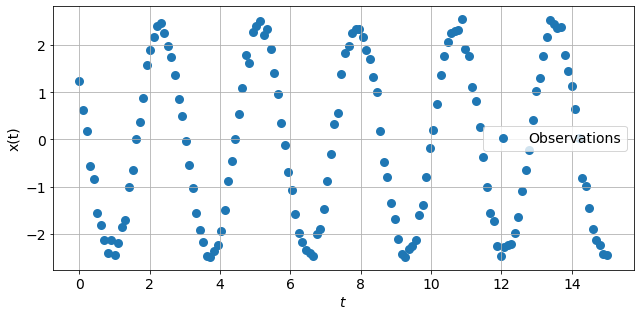

In [5]:
# Plot the observations

plt.figure(figsize=(9, 4.5))
plt.scatter(t, x, linewidth=3, label="Observations")
plt.xlabel(r'$t$', size=14)
plt.xticks(size=14)
plt.ylabel(r"x(t)", size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.tight_layout()
plt.show()

## Init $\beta$

In [6]:
beta = np.array([2, 2, 2])

print("Output:")
beta

Output:


array([2, 2, 2])

## Simulation

Calculate coordinates $\hat{x}_{i}$ of the simulation:

$$
\hat{x}_{i} = a \sin{\omega t_{i}} + b \cos{\omega t_{i}}
$$

where $a = \beta[0]$, $b = \beta[1]$ and $\omega = \beta[2]$.

In [7]:
def simulation(beta):
    a = beta[0]
    b = beta[1]
    w = beta[2]
    x_hat = a * np.sin(w*t) + b * np.cos(w*t)
    return x_hat

x_hat = simulation(beta)

print("Output:")
x_hat[:2]

Output:


array([2.        , 2.36059269])

Expected otput :  
`[2.        , 2.36059269]`

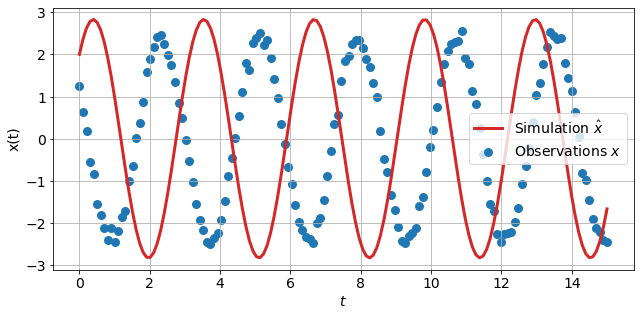

In [8]:
# Plot the simulation
plt.figure(figsize=(9, 4.5))
plt.scatter(t, x, linewidth=3, label=r"Observations $x$")
plt.plot(t, x_hat, linewidth=3, label=r"Simulation $\hat{x}$", color='C3')
plt.xlabel(r'$t$', size=14)
plt.xticks(size=14)
plt.ylabel(r"x(t)", size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.tight_layout()
plt.show()

## Loss

Calculate the loss function defined as:

$$
L(\beta) = \frac{1}{n} \sum_{i=1}^{n} (\hat{x}_{i} - x_{i})^{2}
$$

In [9]:
def loss_func(beta):
    x_hat = simulation(beta)
    loss = np.mean( (x_hat - x)**2 )
    return loss

loss = loss_func(beta)

print("Output:")
loss

Output:


9.891016015072731

Expected otput :  
`9.891016015072731`

## Gradient of the loss function

Calculate gradient of the loss function $\nabla L$ defined as:
    
$$
\nabla L(\beta) = \left( \begin{array}{c} 
         \frac{ \partial L(\beta) }{ \partial a } \\ 
         \frac{ \partial L(\beta) }{ \partial b } \\
         \frac{ \partial L(\beta) }{ \partial \omega } \\
         \end{array} \right)
$$

where

$$
\frac{ \partial L(\beta) }{ \partial a } = \frac{2}{n} \sum_{i=1}^{n} (\hat{x}_{i} - x_{i}) \sin{\omega t_{i}}
$$

$$
\frac{ \partial L(\beta) }{ \partial b } = \frac{2}{n} \sum_{i=1}^{n} (\hat{x}_{i} - x_{i}) \cos{\omega t_{i}}
$$

$$
\frac{ \partial L(\beta) }{ \partial \omega } = \frac{2}{n} \sum_{i=1}^{n} (\hat{x}_{i} - x_{i}) (a t_{i} \cos{\omega t_{i}} - b t_{i} \sin{\omega t_{i}})
$$

In [10]:
def grad_func(beta):
    a = beta[0]
    b = beta[1]
    w = beta[2]
    x_hat = simulation(beta)
    grad_a = 2. / len(x) * ( (x_hat - x) * np.sin(w*t) ).sum() 
    grad_b = 2. / len(x) * ( (x_hat - x) * np.cos(w*t) ).sum()
    grad_w = 2. / len(x) * ( (x_hat - x) * (a * t * np.cos(w*t) - b * t * np.sin(w*t)) ).sum() 
    grad = np.array([grad_a, grad_b, grad_w])
    return grad

grad = grad_func(beta)

print("Output:")
grad

Output:


array([ 2.28446199,  3.26442154, 31.64552842])

Expected otput :  
`[ 2.28446199,  3.26442154, 31.64552842]`

## Gradient descent with momentum

Now implement gradient descent with momentum. The update rule for $\beta$ is:

$$
v_{k} = \gamma v_{k-1} + \alpha \nabla L(\beta_{k})
$$

$$
\beta_{k+1} = \beta_{k} + v_{k}
$$

With stop criterion:

$$
| L(\beta_{(t)}) - L(\beta_{(t-1)}) | < 10^{-6}
$$

In [11]:
alpha = 0.001                # learning rate
gamma = 0.9                   # momentum term
beta = np.array([-2, 2, 2])    # init beta, again :)

beta_collector = [beta]
loss_collector = [loss_func(beta)]
v = 0

for i_iter in range(5000): # for each iteration
    # Calculate gradient
    grad = grad_func(beta)
    # Update beta
    v = gamma * v + alpha * grad
    beta = beta - v
    # Save new beta
    beta_collector.append(beta)
    # Calculate loss
    loss = loss_func(beta)
    # Save loss
    loss_collector.append(loss)
    
    # Stop criterion
    if np.abs( loss_collector[-1] - loss_collector[-2] ) < 10**-6:
        print("Iteration: ", i_iter)
        print("Beta: ", beta)
        print("Loss: ", loss)
        break

Iteration:  1085
Beta:  [-2.10542847  1.18522405  2.24866869]
Loss:  0.011229720570278006


In [12]:
# Calculate simulation
x_hat = simulation(beta)

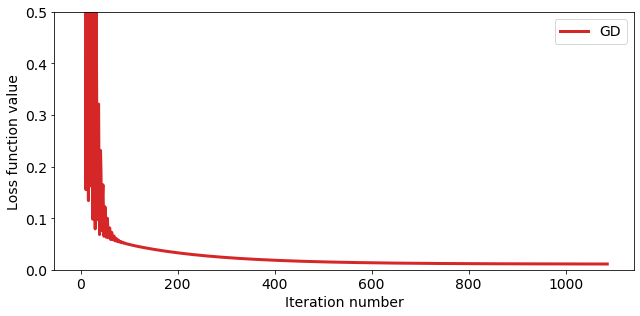

In [13]:
# Plot learning curve
plt.figure(figsize=(9, 4.5))
plt.plot(loss_collector, linewidth=3, label="GD", color='C3')
plt.xlabel(r'Iteration number', size=14)
plt.xticks(size=14)
plt.ylabel(r"Loss function value", size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14, ncol=2)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

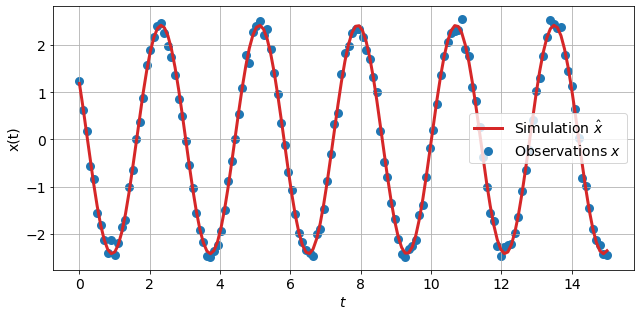

In [14]:
# Plot the simulation
plt.figure(figsize=(9, 4.5))
plt.scatter(t, x, linewidth=3, label=r"Observations $x$")
plt.plot(t, x_hat, linewidth=3, label=r"Simulation $\hat{x}$", color='C3')
plt.xlabel(r'$t$', size=14)
plt.xticks(size=14)
plt.ylabel(r"x(t)", size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.tight_layout()
plt.show()